In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
import networkx as nx
import torch
import torch_geometric
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [56]:
# defines 
HALF_SECOND = 0.5
NUM_CLASSES = 2
NUM_FEATURES = 31

In [3]:
# load the keystroke data
df_51 = pd.read_csv("DSL-StrongPasswordData.csv")
display(df_51.iloc[:5])

# load the demographic data
df_dem = pd.read_csv("demographics.txt", sep=" ")
df_dem.iloc[:5]

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


,subject,gender,age,race,education,major,native.language,handedness,typingskill
0,s002,Female,18-30,Caucasian,Undergrad,Computer Science,English,Right,Touch
1,s003,Female,31+,Asian,Ph.D. student,-,Cebuano,Right,Touch
2,s004,Female,18-30,Caucasian,Ph.D. student,-,English,Right,Other
3,s005,Female,18-30,African,Ph.D. student,-,Swahili,Right,Other
4,s007,Male,18-30,Caucasian,Undergrad,Computer Science,English,Right,Touch


In [4]:
# get the total typing time for each repetition
totaltimes = df_51.filter(regex='H|UD').sum(axis=1)
df = pd.concat([df_51.subject, totaltimes], axis=1)

# average the total typing times for each subject (and sort them)
df_avg_totaltime = df.groupby('subject').mean().sort_values(0)
df_avg_totaltime.columns = ["average totaltime"]

df_avg_totaltime.iloc[:5]

,average totaltime
subject,
s055,1.477592
s013,1.693144
s051,1.743740
s053,1.782783
s010,1.782906


In [5]:
# subject list subset by age demogephic
under30_subs = df_dem[df_dem.gender == "Male"].subject.unique()
over30_subs = df_dem[~(df_dem.gender == "Male")].subject.unique()

# subject list subset by touch-typing skill
touch_subs = df_dem[df_dem.typingskill == "Touch"].subject.unique()
notouch_subs = df_dem[~(df_dem.typingskill == "Touch")].subject.unique()

In [6]:
# get the keystroke data for each age subset
under30_totaltimes = df_avg_totaltime[df_avg_totaltime.index.isin(under30_subs)]
over30_totaltimes = df_avg_totaltime[df_avg_totaltime.index.isin(over30_subs)]

# get the keystroke data for each typist skill subset
touch_totaltimes = df_avg_totaltime[df_avg_totaltime.index.isin(touch_subs)]
notouch_totaltimes = df_avg_totaltime[df_avg_totaltime.index.isin(notouch_subs)]

In [7]:
def plot_touching_subplots(df1, df2, suptitle="", p1title="", p2title=""):
    # big figure with touching subplots
    fig, ax = plt.subplots(1,2, figsize=(15,10), sharey=True, gridspec_kw = {'wspace':0})

    # plot the data for each subset
    ax[0].plot(df1, '.', color='black')
    ax[1].plot(df2,  '.', color='black')

    # set limits
    ax[0].set_ylim(1,5.5)
    ax[1].set_ylim(1,5.5)

    # modify ticks
    ax[0].tick_params(axis='x', which='major', labelsize=10, rotation=90)
    ax[0].tick_params(axis='y', which='major', labelsize=13)
    ax[1].tick_params(axis='x', which='major', labelsize=10, rotation=90)

    # set labels
    ax[0].set_xlabel("Subject", fontsize=15)
    ax[0].set_ylabel("Total Typing Time in Seconds", fontsize=15)
    ax[1].set_xlabel("Subject", fontsize=15)

    # set titles
    ax[0].set_title(p1title, fontsize=15)
    ax[1].set_title(p2title, fontsize=15)
    plt.suptitle(suptitle, fontsize=20, y=0.95)

    plt.show()

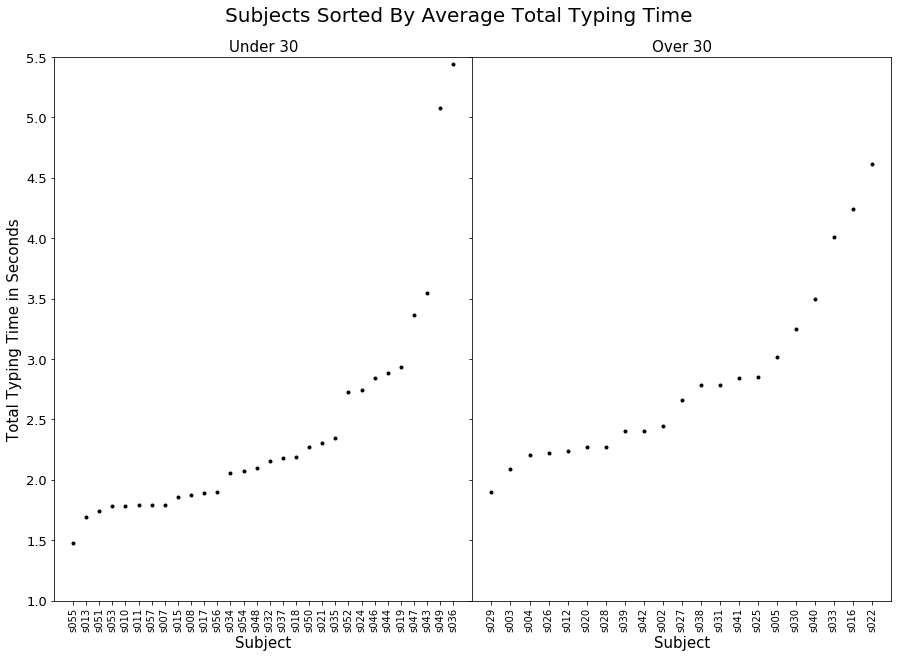

In [8]:
plot_touching_subplots(under30_totaltimes, over30_totaltimes, 
                       suptitle="Subjects Sorted By Average Total Typing Time",
                       p1title="Under 30", p2title="Over 30")

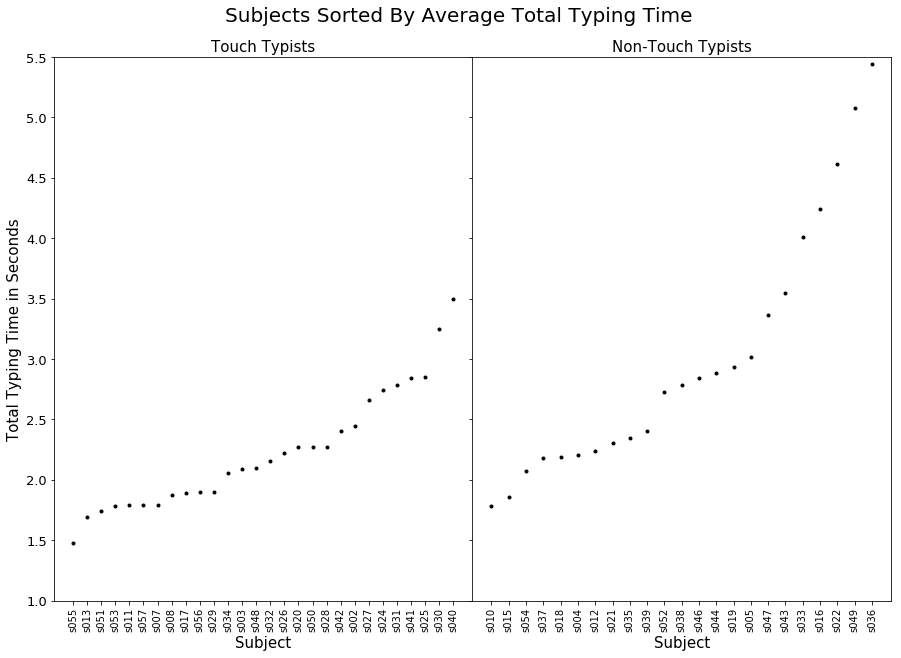

In [9]:
plot_touching_subplots(touch_totaltimes, notouch_totaltimes, 
                       suptitle="Subjects Sorted By Average Total Typing Time",
                       p1title="Touch Typists", p2title="Non-Touch Typists")

It seems that touch typists vs non-touch typists is the better of the two representations, with a reasonable amount of distinction between the two classes. 

In [10]:
def graph_from_adj(adjacency_matrix):
    return nx.from_numpy_matrix(np.matrix(adjacency_matrix), create_using=nx.DiGraph)

def plot_graph_from_adj(adjacency_matrix):
    G = graph_from_adj(adjacency_matrix)
    # k controls the distance between the nodes and varies between 0 and 1
    # iterations is the number of times simulated annealing is run
    # default k =0.1 and iterations=50
    layout = nx.spring_layout(G,k=0.1,iterations=100)
    nx.draw(G, layout, with_labels=False)

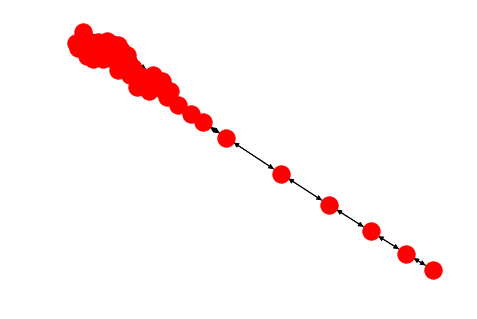

In [11]:
# compute euclidean distances pairwise between subjects. 
# threshold by a half-second to get the adjacency matrix.
A = (euclidean_distances(df_avg_totaltime.values) < HALF_SECOND).astype(int)
plot_graph_from_adj(A)

Given the plots above, this graph structure is, perhaps, unsurprising. We will see if it contains enough information for the network to utilize.

In [16]:
A

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [110]:
def get_train_test(df):
    train = df.groupby('subject').apply(lambda x: x).sample(frac=0.7)
    test = df[~df.index.isin(train.index)]
    assert(len(test) + len(train) == len(df))
    train_labels = train.subject.isin(touch_subs)
    test_labels = test.subject.isin(touch_subs)
    train = train.filter(regex='H|UD|DD')
    test = test.filter(regex='H|UD|DD')
    return train.values, train_labels.values.astype(int), test.values, test_labels.values.astype(int)


In [119]:
train, train_labels, test, test_labels = get_train_test(df_51)
train, train_labels

(array([[0.0857, 0.9648, 0.8791, ..., 1.0924, 1.0159, 0.0881],
        [0.0681, 0.2872, 0.2191, ..., 0.3696, 0.296 , 0.0633],
        [0.0866, 0.1675, 0.0809, ..., 0.2367, 0.1308, 0.0953],
        ...,
        [0.0779, 0.7988, 0.7209, ..., 0.833 , 0.7654, 0.0697],
        [0.0631, 0.2583, 0.1952, ..., 0.2691, 0.2226, 0.0449],
        [0.1154, 0.2919, 0.1765, ..., 0.6897, 0.572 , 0.1124]]),
 array([0, 0, 1, ..., 0, 1, 0]))

In [120]:
G = graph_from_adj(A)
data = torch_geometric.utils.convert.from_networkx(G)

# load train data
data.x = torch.from_numpy(train)
data.y = torch.from_numpy(train_labels)

In [121]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(NUM_FEATURES, 16)
        self.conv2 = GCNConv(16, NUM_CLASSES)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    model = model.float()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    print(loss)
    optimizer.step()
    

tensor(0.7069, grad_fn=<NllLossBackward>)
tensor(0.6875, grad_fn=<NllLossBackward>)
tensor(0.6805, grad_fn=<NllLossBackward>)
tensor(0.6723, grad_fn=<NllLossBackward>)
tensor(0.6629, grad_fn=<NllLossBackward>)
tensor(0.6552, grad_fn=<NllLossBackward>)
tensor(0.6504, grad_fn=<NllLossBackward>)
tensor(0.6443, grad_fn=<NllLossBackward>)
tensor(0.6401, grad_fn=<NllLossBackward>)
tensor(0.6344, grad_fn=<NllLossBackward>)
tensor(0.6295, grad_fn=<NllLossBackward>)
tensor(0.6273, grad_fn=<NllLossBackward>)
tensor(0.6222, grad_fn=<NllLossBackward>)
tensor(0.6223, grad_fn=<NllLossBackward>)
tensor(0.6177, grad_fn=<NllLossBackward>)
tensor(0.6151, grad_fn=<NllLossBackward>)
tensor(0.6092, grad_fn=<NllLossBackward>)
tensor(0.6078, grad_fn=<NllLossBackward>)
tensor(0.6040, grad_fn=<NllLossBackward>)
tensor(0.6067, grad_fn=<NllLossBackward>)
tensor(0.6051, grad_fn=<NllLossBackward>)
tensor(0.5983, grad_fn=<NllLossBackward>)
tensor(0.5998, grad_fn=<NllLossBackward>)
tensor(0.5987, grad_fn=<NllLossBac

tensor(0.5041, grad_fn=<NllLossBackward>)
tensor(0.5038, grad_fn=<NllLossBackward>)


In [124]:
# load test data
data.x = torch.from_numpy(test)
data.y = torch.from_numpy(test_labels)

model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred.eq(data.y).sum().item())
acc = correct / len(test_labels)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7868
